In [1]:
# 📦 Step 1: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [4]:
# 📥 Step 2: Load Data
df = pd.read_csv("C:\\Users\\DELL\\Desktop\\medical-cost-prediction\\data\\insurance.csv")
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [5]:
# 🔍 Step 3: EDA
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max

<Axes: >

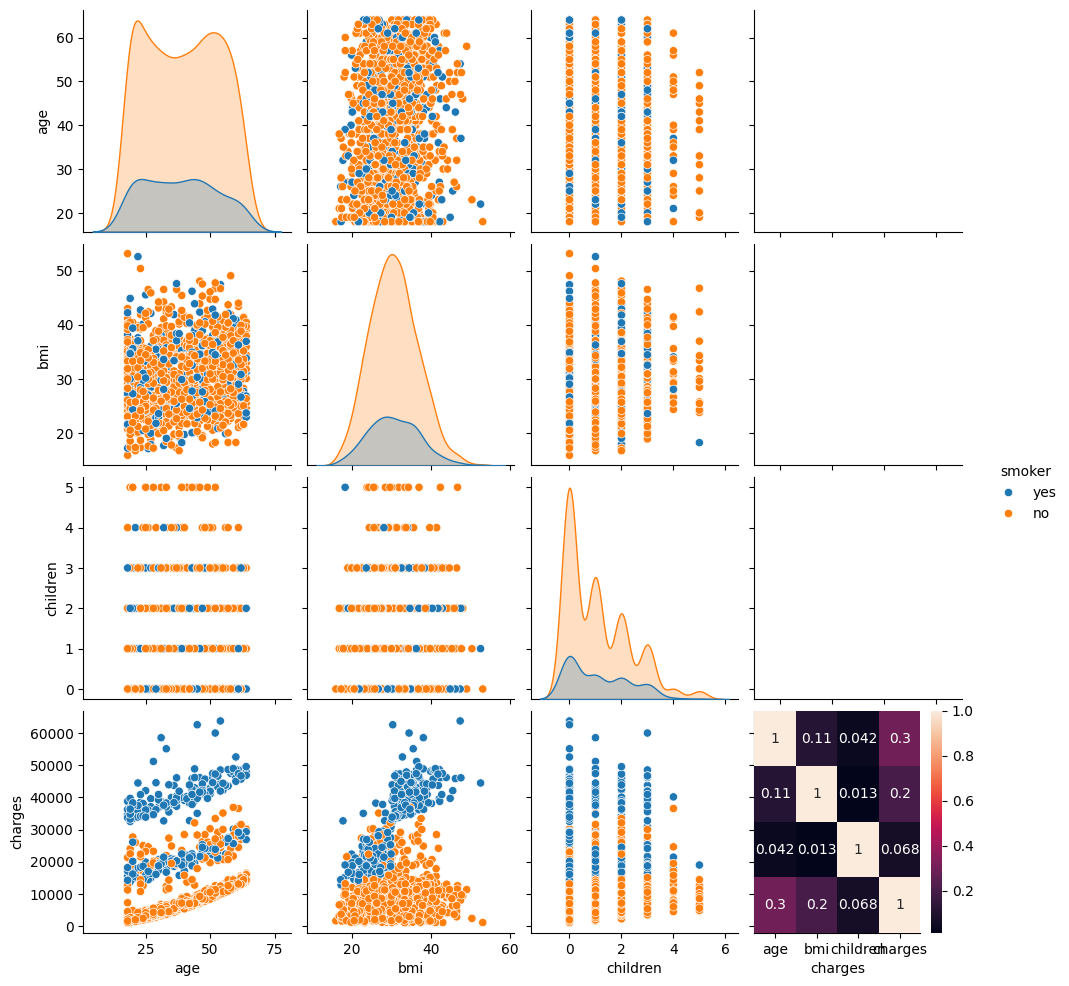

In [6]:
# Visuals
sns.pairplot(df, hue='smoker')
sns.boxplot(x='smoker', y='charges', data=df)
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [8]:
# 🛠️ Step 4: Preprocessing
X = df.drop('charges', axis=1)
y = df['charges']

numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

In [9]:
# Define preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

In [10]:
# 📈 Step 5: Modeling Pipeline
model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

# 🔁 Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# 🚂 Train
model.fit(X_train, y_train)

# 📊 Step 7: Evaluate
y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 5796.284659276275
R² Score: 0.7835929767120722


# Interpretation
RMSE ≈ 5800 means the average prediction error is around $5800 — not bad considering some insurance costs exceed $50,000.

R² Score ≈ 0.78 indicates that your model explains 78% of the variance in medical costs — that’s a very strong start.

# We’ll:

Reuse the same preprocessing pipeline ✅

Plug in RandomForestRegressor and XGBRegressor instead of LinearRegression

Compare RMSE and R² side by side

In [12]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [13]:
def train_and_evaluate(model, model_name):
    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n📈 Results for {model_name}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    return pipe


In [14]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pipe = train_and_evaluate(rf_model, "Random Forest Regressor")

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb_pipe = train_and_evaluate(xgb_model, "XGBoost Regressor")



📈 Results for Random Forest Regressor
RMSE: 4567.78
R² Score: 0.8656

📈 Results for XGBoost Regressor
RMSE: 4284.88
R² Score: 0.8817


# 📊 Model Performance Summary
Model | RMSE | R² Score
1. Linear Regression | 5796.28 | 0.7836
2. Random Forest | 4567.78 | 0.8656
3. XGBoost 🚀 | 4284.88 | 0.8817

#  Interpretation
XGBoost outperformed the others — lower RMSE and highest R².

It’s capturing more complex, non-linear relationships in the data.

# Step 2: SHAP Analysis for XGBoost Regressor
We’ll use the trained xgb_model (before pipeline) to:

1. Calculate SHAP values

2. Plot global feature importance

3. (Optionally) Analyze individual predictions

In [15]:
import shap
import xgboost
import matplotlib.pyplot as plt


# Prepare the Data
Since SHAP doesn’t work well with pipelines directly, we’ll:

1. Use the preprocessed training data

2. Use the original XGBoost model, not the pipeline

In [16]:
# Fit transformer only
X_train_transformed = preprocessor.fit_transform(X_train)

# Convert to DataFrame for SHAP plotting (optional)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)


In [17]:
# Create explainer for tree-based models
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values
shap_values = explainer(X_train_df)


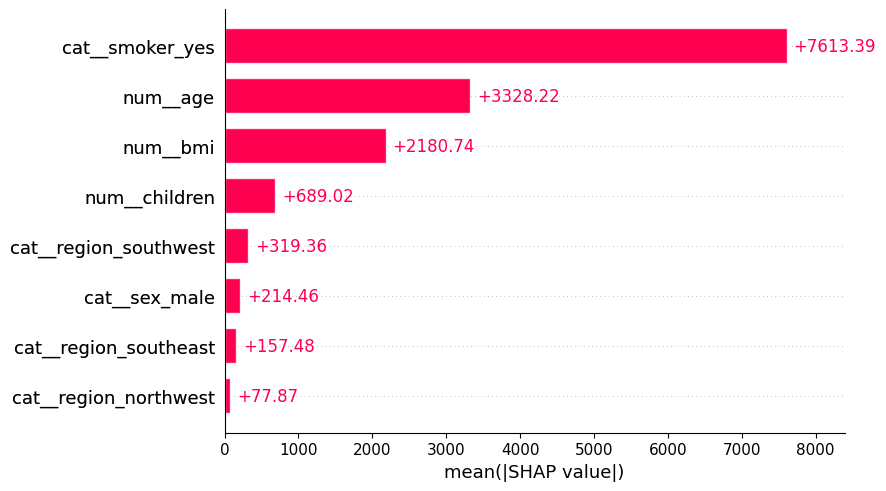

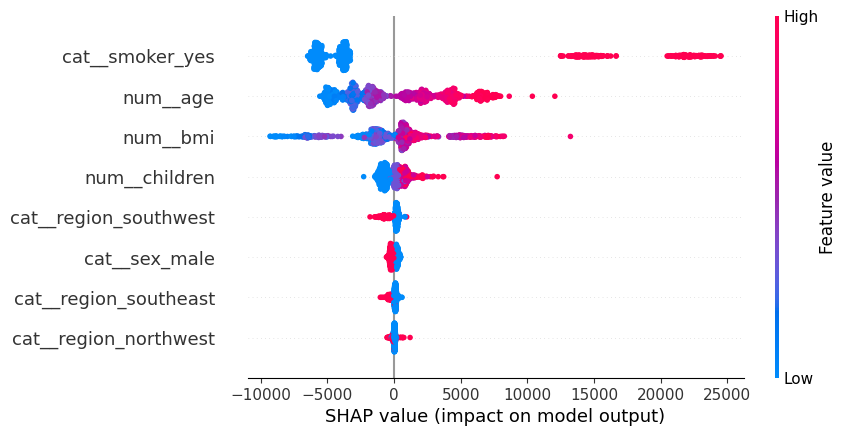

In [18]:
# Summary plot (bar): global feature importance
shap.plots.bar(shap_values, max_display=10)

# Summary plot (beeswarm): distribution of impact per feature
shap.plots.beeswarm(shap_values, max_display=10)


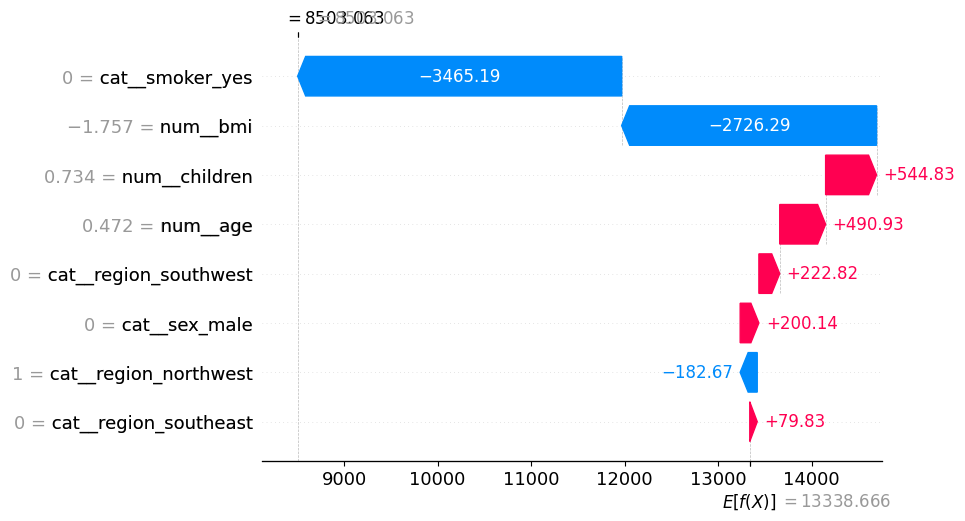

In [19]:
# Choose an individual example
sample_index = 0
shap.plots.waterfall(shap_values[sample_index])


In [20]:
import joblib


In [23]:
# Fit on full dataset (just to ensure it's up to date)
preprocessor.fit(X_train)

# Save it
joblib.dump(preprocessor, "C:\\Users\\DELL\\Desktop\\medical-cost-prediction\\models/preprocessor.pkl")


['C:\\Users\\DELL\\Desktop\\medical-cost-prediction\\models/preprocessor.pkl']

In [24]:
# Save the trained XGBoost model
joblib.dump(xgb_model, "C:\\Users\\DELL\\Desktop\\medical-cost-prediction\\models/xgb_model.pkl")


['C:\\Users\\DELL\\Desktop\\medical-cost-prediction\\models/xgb_model.pkl']

In [26]:
# Just to confirm
loaded_model = joblib.load("C:\\Users\\DELL\\Desktop\\medical-cost-prediction\\models/xgb_model.pkl")
loaded_preprocessor = joblib.load("C:\\Users\\DELL\\Desktop\\medical-cost-prediction\\models/preprocessor.pkl")
